# End-to-End Data Science Project: A Comprehensive Guide for Beginners


**Author:** Dhanush Kobal


In this project, we will walk through a complete data science process, from web-scraping to creating various machine learning models. We will perform exploratory data analysis (EDA), conduct statistical tests, and draw insights from our findings. Throughout the project, we will apply various data science concepts, such as hyperparameter tuning, random forest importance, ensemble learning, and k-fold cross-validation, to showcase a real-world end-to-end data science project.


In [1]:
import os

# Set up Kaggle API key
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

# Ensure the kaggle.json file is present
!ls -la kaggle.json

-rw-r--r-- 1 root root 70 Mar 26 22:40 kaggle.json


In [2]:
!kaggle competitions download -c store-sales-time-series-forecasting


store-sales-time-series-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip store-sales-time-series-forecasting.zip

Archive:  store-sales-time-series-forecasting.zip
replace holidays_events.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: No




# Load Data

Import the necessary libraries for EDA, visualization, and data manipulation

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Load the data into pandas DataFrames

In [5]:
holidays_events = pd.read_csv('holidays_events.csv')
oil = pd.read_csv('oil.csv')
sample_submission = pd.read_csv('sample_submission.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
transactions = pd.read_csv('transactions.csv')

Let's start with some basic EDA by checking the shape, data types, and summary statistics of the data

In [6]:
# List of dataframes and their names for easy iteration
dataframes = [
    (holidays_events, "holidays_events"),
    (oil, "oil"),
    (stores, "stores"),
    (test, "test"),
    (train, "train"),
    (transactions, "transactions"),
]

# Print basic information for each dataframe
for df, name in dataframes:
    print(f"{name.upper()} DATA")
    print("Shape:", df.shape)
    print("\nData Types:")
    print(df.dtypes)
    print("\nSummary Statistics:")
    print(df.describe(include='all'))
    print("\n")


HOLIDAYS_EVENTS DATA
Shape: (350, 6)

Data Types:
date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

Summary Statistics:
              date     type    locale locale_name description transferred
count          350      350       350         350         350         350
unique         312        6         3          24         103           2
top     2014-06-25  Holiday  National     Ecuador    Carnaval       False
freq             4      221       174         174          10         338


OIL DATA
Shape: (1218, 2)

Data Types:
date           object
dcoilwtico    float64
dtype: object

Summary Statistics:
              date   dcoilwtico
count         1218  1175.000000
unique        1218          NaN
top     2013-01-01          NaN
freq             1          NaN
mean           NaN    67.714366
std            NaN    25.630476
min            NaN    26.190000
25%            NaN    46.405000
50%  

# EDA

Let's start by visualizing the distribution of sales in the train dataset. This will give us a better understanding of the overall sales pattern

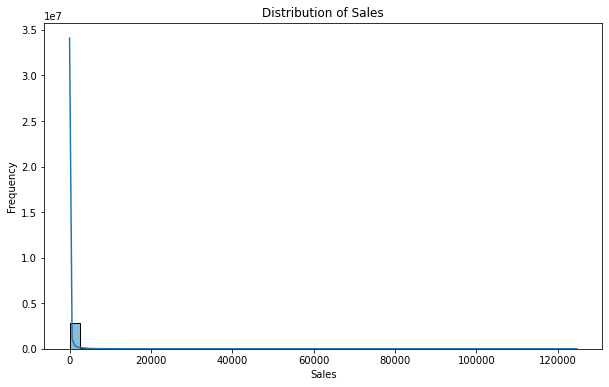

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(train['sales'], bins=50, kde=True)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.show()


Result: In summary, the sales distribution is heavily right-skewed, with most product families having relatively low sales and only a few product families achieving very high sales

Let's apply the log transformation to the sales column and visualize the new distribution

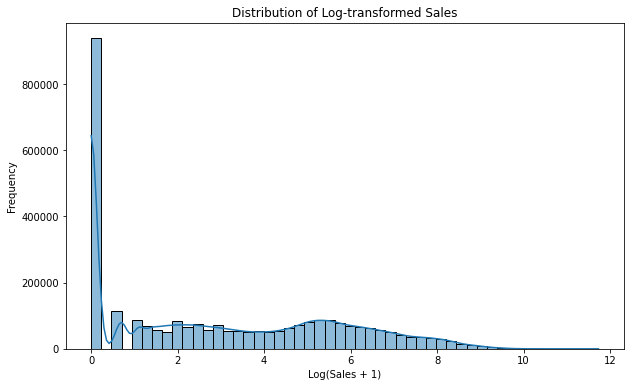

In [8]:
train['log_sales'] = np.log1p(train['sales'])

plt.figure(figsize=(10, 6))
sns.histplot(train['log_sales'], bins=50, kde=True)
plt.xlabel('Log(Sales + 1)')
plt.ylabel('Frequency')
plt.title('Distribution of Log-transformed Sales')
plt.show()


Create bins and visualize average sales by the number of items on promotion

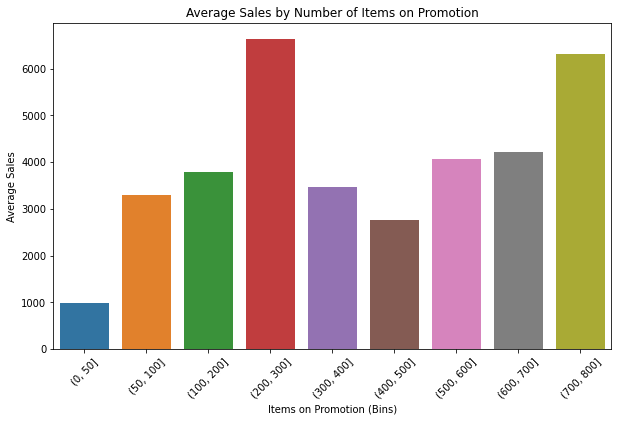

In [9]:
# Create bins for the number of items on promotion
promotion_sales = train.groupby('onpromotion')['sales'].sum().reset_index()
promotion_counts = train['onpromotion'].value_counts().reset_index()
promotion_counts.columns = ['onpromotion', 'count']

promotion_sales = promotion_sales.merge(promotion_counts, on='onpromotion')
promotion_sales['average_sales'] = promotion_sales['sales'] / promotion_sales['count']



bins = [0, 50, 100, 200, 300, 400, 500, 600, 700, 800]
promotion_sales['binned'] = pd.cut(promotion_sales['onpromotion'], bins)

# Calculate average sales for each bin
binned_sales = promotion_sales.groupby('binned')['sales'].sum().reset_index()
binned_counts = promotion_sales.groupby('binned')['count'].sum().reset_index()

binned_sales = binned_sales.merge(binned_counts, on='binned')
binned_sales['average_sales'] = binned_sales['sales'] / binned_sales['count']

# Plot the average sales by the number of items on promotion in each bin
plt.figure(figsize=(10, 6))
sns.barplot(x='binned', y='average_sales', data=binned_sales)
plt.xlabel('Items on Promotion (Bins)')
plt.ylabel('Average Sales')
plt.title('Average Sales by Number of Items on Promotion')
plt.xticks(rotation=45)
plt.show()


In [10]:
binned_sales

,binned,sales,count,average_sales
0,"(0, 50]",5.670906e+08,575058,986.145113
1,"(50, 100]",9.029565e+07,27355,3300.882681
2,"(100, 200]",2.767065e+07,7305,3787.905058
3,"(200, 300]",1.008739e+07,1518,6645.186823
4,"(300, 400]",7.269000e+04,21,3461.428571
5,"(400, 500]",6.880200e+04,25,2752.080000
6,"(500, 600]",5.702900e+04,14,4073.500000
7,"(600, 700]",9.293737e+04,22,4224.425773
8,"(700, 800]",6.939000e+04,11,6308.181818


Investigate the relationship between store attributes (city, state, type, and cluster) and sales

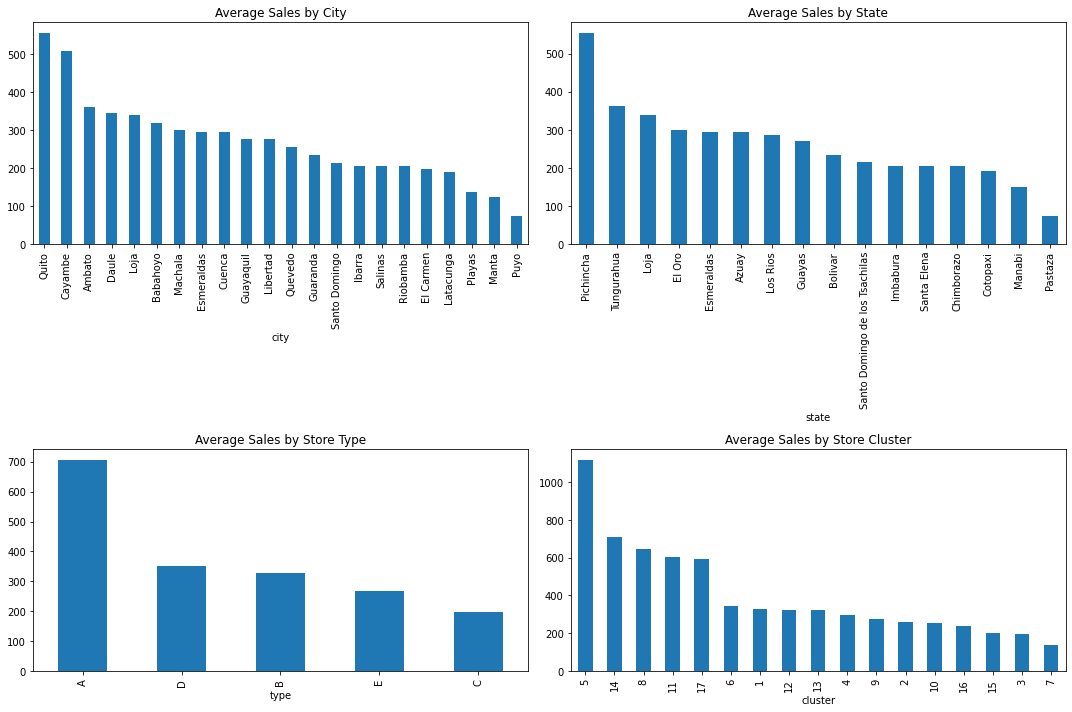

In [11]:
train_stores = train.merge(stores, on="store_nbr")

# Average sales by city
city_sales = train_stores.groupby("city")["sales"].mean().sort_values(ascending=False)

# Average sales by state
state_sales = train_stores.groupby("state")["sales"].mean().sort_values(ascending=False)

# Average sales by store type
type_sales = train_stores.groupby("type")["sales"].mean().sort_values(ascending=False)

# Average sales by store cluster
cluster_sales = train_stores.groupby("cluster")["sales"].mean().sort_values(ascending=False)

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

city_sales.plot(kind="bar", ax=axes[0, 0], title="Average Sales by City")
state_sales.plot(kind="bar", ax=axes[0, 1], title="Average Sales by State")
type_sales.plot(kind="bar", ax=axes[1, 0], title="Average Sales by Store Type")
cluster_sales.plot(kind="bar", ax=axes[1, 1], title="Average Sales by Store Cluster")

plt.tight_layout()
plt.show()


Analyzing the Effect of Holidays and Events on Sales

In [12]:
# Step 1: Convert the 'date' column to a datetime data type
train_stores['date'] = pd.to_datetime(train_stores['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

# Step 2: Merge the train_stores and holidays_events datasets on the 'date' column
train_stores_holidays = train_stores.merge(holidays_events, on='date', how='left')

# Marking rows as holiday or non-holiday
train_stores_holidays['is_holiday'] = train_stores_holidays['type_y'].apply(lambda x: 1 if x == 'Holiday' else 0)

# Calculate average sales for holidays and non-holidays
average_sales_holiday = train_stores_holidays[train_stores_holidays['is_holiday'] == 1]['sales'].mean()
average_sales_non_holiday = train_stores_holidays[train_stores_holidays['is_holiday'] == 0]['sales'].mean()

print(f"Average sales on holidays: {average_sales_holiday}")
print(f"Average sales on non-holidays: {average_sales_non_holiday}")

# Grouping data by event type and calculating average sales
event_sales = train_stores_holidays.groupby('type_y')['sales'].mean().reset_index().sort_values(by='sales', ascending=False)

print(event_sales)


Average sales on holidays: 358.4338115476292
Average sales on non-holidays: 359.0859543384566
       type_y       sales
0  Additional  487.628925
4    Transfer  467.753110
1      Bridge  446.750854
2       Event  425.660065
5    Work Day  372.157524
3     Holiday  358.433812


result:

Additional: 487.63

*   These are days when additional holidays are declared. Sales on these days have the highest average among all event types.


Transfer: 467.75

*   These are days when a holiday is transferred from its original date. Sales on these days have the second-highest average among all event types.

Bridge: 446.75

*   These are days when a "bridge" holiday is declared to create a long weekend. Sales on these days have the third-highest average among all event types.

Event: 425.66

*   These are special event days (e.g., local celebrations). Sales on these days have the fourth-highest average among all event types.

Work Day: 372.16

*   These are days when a workday is scheduled on a weekend to make up for a holiday. Sales on these days have the fifth-highest average among all event types.

Holiday: 358.43

*   These are regular holiday days, as mentioned earlier. Sales on these days have the lowest average among all event types.


# Data Preperation

Merging data

In [13]:
train['date'] = pd.to_datetime(train['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
oil['date'] = pd.to_datetime(oil['date'])
transactions['date'] = pd.to_datetime(transactions['date'])

train_stores = train.merge(stores, on='store_nbr', how='left')
train_stores_holidays = train_stores.merge(holidays_events, on='date', how='left')

train_stores_holidays_oil = train_stores_holidays.merge(oil, on='date', how='left')

train_stores_holidays_oil_transactions = train_stores_holidays_oil.merge(transactions, on=['date', 'store_nbr'], how='left')


In [14]:
missing_values = train_stores_holidays_oil_transactions.isnull().sum()
print(missing_values)


id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
log_sales             0
city                  0
state                 0
type_x                0
cluster               0
type_y          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dcoilwtico       955152
transactions     249117
dtype: int64


Missing value Analysis



> dcoilwtico: This column represents oil prices. Missing values here might mean the data for those dates was not available. You can choose to interpolate the missing values (linear interpolation, for example), use forward or backward fill, or fill them with the mean or median value of the column, depending on the specific requirements of your analysis.



In [15]:
# Fill missing oil prices with forward/backward fill method
train_stores_holidays_oil_transactions['dcoilwtico'].fillna(method='ffill', inplace=True)
train_stores_holidays_oil_transactions['dcoilwtico'].fillna(method='bfill', inplace=True)

<Axes: >

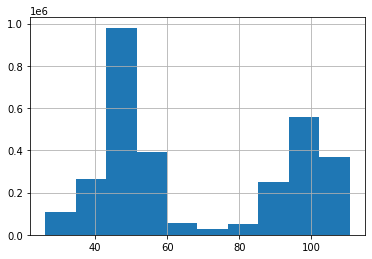

In [16]:
train_stores_holidays_oil_transactions['dcoilwtico'].hist()



> transactions: This column represents the number of transactions in a store on a particular date. Missing values here might indicate a lack of data for those dates. You could fill these missing values with the mean or median number of transactions for each store or use more advanced techniques such as time-series forecasting to estimate the missing values.



In [17]:
# Fill missing transactions with the median number of transactions for each store
store_median_transactions = train_stores_holidays_oil_transactions.groupby('store_nbr')['transactions'].median()
train_stores_holidays_oil_transactions['transactions'] = train_stores_holidays_oil_transactions.apply(
    lambda row: store_median_transactions[row['store_nbr']] if pd.isnull(row['transactions']) else row['transactions'],
    axis=1
)

In [18]:
missing_values = train_stores_holidays_oil_transactions.isnull().sum()
print(missing_values)

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
log_sales             0
city                  0
state                 0
type_x                0
cluster               0
type_y          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dcoilwtico            0
transactions          0
dtype: int64




> type_y, locale, locale_name, description, and transferred: These columns are related to holidays_events data. The missing values here probably indicate that there was no holiday or event on those dates. You can create a new binary column, for example, is_holiday_or_event, where you set the value to 1 if there's a holiday/event on that date and 0 otherwise. You can then drop the original holiday/event columns if they are not required for further analysis.



In [19]:
# Create 'is_holiday_or_event' column and drop original holiday/event columns
train_stores_holidays_oil_transactions['is_holiday_or_event'] = train_stores_holidays_oil_transactions['type_y'].notnull().astype(int)
train_stores_holidays_oil_transactions.drop(['type_y', 'locale', 'locale_name', 'description', 'transferred'], axis=1, inplace=True)

In [20]:
missing_values = train_stores_holidays_oil_transactions.isnull().sum()
print(missing_values)

id                     0
date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
log_sales              0
city                   0
state                  0
type_x                 0
cluster                0
dcoilwtico             0
transactions           0
is_holiday_or_event    0
dtype: int64


##Seasonality analysis

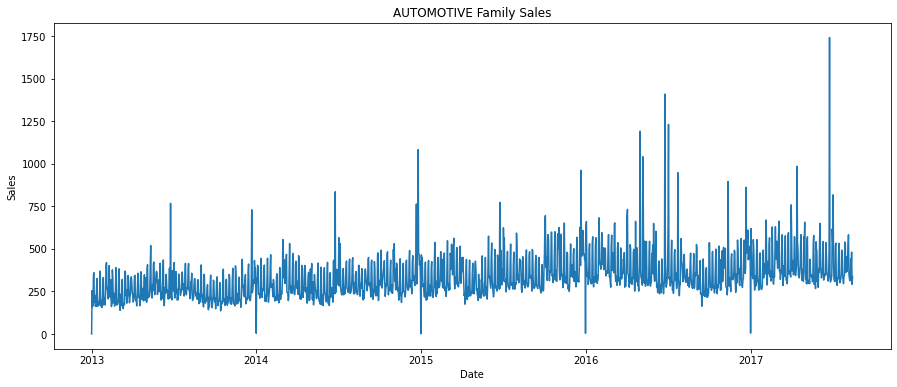

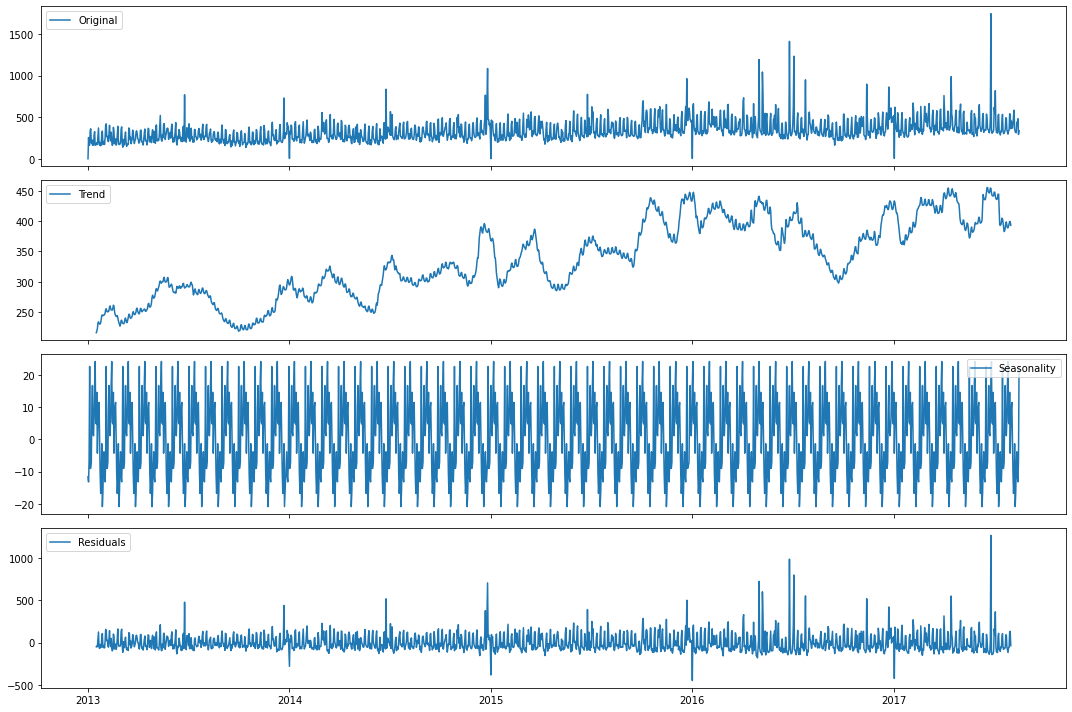

In [21]:
#Aggregate the data by date and family to obtain the total sales for each family on a given day.
aggregated_data = train_stores_holidays_oil_transactions.groupby(['date', 'family'])['sales'].sum().reset_index()

#Filter the data for a specific product family. For example, if you want to analyze the sales of the 'AUTOMOTIVE' family.
family_data = aggregated_data[aggregated_data['family'] == 'AUTOMOTIVE']

#Set the 'date' as the index for the time series analysis.
family_data = family_data.set_index('date')

# Plot the time series data to visualize the trend and seasonality.
plt.figure(figsize=(15, 6))
plt.plot(family_data['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('AUTOMOTIVE Family Sales')
plt.show()

# Decompose the time series into its components (trend, seasonality, and residuals) to analyze them separately.
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(family_data['sales'], model='additive', period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#Plot the decomposed components.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
ax1.plot(family_data['sales'], label='Original')
ax1.legend(loc='best')
ax2.plot(trend, label='Trend')
ax2.legend(loc='best')
ax3.plot(seasonal, label='Seasonality')
ax3.legend(loc='best')
ax4.plot(residual, label='Residuals')
ax4.legend(loc='best')
plt.tight_layout()
plt.show()


In [22]:
family_data = family_data.reset_index()
family_data['year'] = family_data['date'].dt.year
family_data['month'] = family_data['date'].dt.month
family_data['day'] = family_data['date'].dt.day

In [23]:
# Save the original display options
#original_max_rows = pd.options.display.max_rows

# Set the display options to show all rows
#pd.options.display.max_rows = None

#pd.options.display.max_rows = original_max_rows

# Create a boolean mask for the date range (December 2013 - January 2014)

mask = (family_data['date'] >= '2013-12-01') & (family_data['date'] <= '2014-01-31')

# Filter the DataFrame using the mask
filtered_family_data = family_data[mask]

# Display the filtered data
print(filtered_family_data)


          date      family  sales  year  month  day
334 2013-12-01  AUTOMOTIVE  439.0  2013     12    1
335 2013-12-02  AUTOMOTIVE  278.0  2013     12    2
336 2013-12-03  AUTOMOTIVE  287.0  2013     12    3
337 2013-12-04  AUTOMOTIVE  230.0  2013     12    4
338 2013-12-05  AUTOMOTIVE  223.0  2013     12    5
..         ...         ...    ...   ...    ...  ...
390 2014-01-27  AUTOMOTIVE  256.0  2014      1   27
391 2014-01-28  AUTOMOTIVE  187.0  2014      1   28
392 2014-01-29  AUTOMOTIVE  215.0  2014      1   29
393 2014-01-30  AUTOMOTIVE  253.0  2014      1   30
394 2014-01-31  AUTOMOTIVE  282.0  2014      1   31

[61 rows x 6 columns]


In [24]:
mask = (train_stores_holidays_oil_transactions['date'] >= '2013-12-30') & (train_stores_holidays_oil_transactions['date'] <= '2014-01-31')
a = train_stores_holidays_oil_transactions
a[ (a.date=='2014-01-02')].head()
#train_stores_holidays_oil_transactions[mask]

,id,date,store_nbr,family,sales,onpromotion,log_sales,city,state,type_x,cluster,dcoilwtico,transactions,is_holiday_or_event
659340,650430,2014-01-02,1,AUTOMOTIVE,3.0,0,1.386294,Quito,Pichincha,D,13,95.14,1875.0,0
659341,650431,2014-01-02,1,BABY CARE,0.0,0,0.000000,Quito,Pichincha,D,13,95.14,1875.0,0
659342,650432,2014-01-02,1,BEAUTY,6.0,0,1.945910,Quito,Pichincha,D,13,95.14,1875.0,0
659343,650433,2014-01-02,1,BEVERAGES,2524.0,0,7.833996,Quito,Pichincha,D,13,95.14,1875.0,0
659344,650434,2014-01-02,1,BOOKS,0.0,0,0.000000,Quito,Pichincha,D,13,95.14,1875.0,0


Result: The dips are caused due to holidays

# Modelling

## Preprocessing and Feature Engineering

In [25]:
# Create lag features
for i in range(1, 8):
    family_data[f'lag_{i}'] = family_data['sales'].shift(i)


In [26]:
# Create rolling window statistics
window_size = 7
family_data['rolling_mean'] = family_data['sales'].rolling(window=window_size).mean()
family_data['rolling_median'] = family_data['sales'].rolling(window=window_size).median()
family_data['rolling_std'] = family_data['sales'].rolling(window=window_size).std()


In [27]:
# Create day of the week and week of the year features
family_data['day_of_week'] = family_data['date'].dt.dayofweek
family_data['week_of_year'] = family_data['date'].dt.isocalendar().week


In [28]:
# One-hot encoding for the 'family' column
family_data = pd.get_dummies(family_data, columns=['family'], drop_first=True)


In [29]:
# Drop rows with missing values
family_data.dropna(inplace=True)
family_data.head()

,date,sales,year,month,day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std,day_of_week,week_of_year
7,2013-01-08,229.0,2013,1,8,189.0,360.0,342.0,169.0,161.0,255.0,0.0,243.571429,229.0,80.564378,1,2
8,2013-01-09,164.0,2013,1,9,229.0,189.0,360.0,342.0,169.0,161.0,255.0,230.571429,189.0,85.597619,2,2
9,2013-01-10,164.0,2013,1,10,164.0,229.0,189.0,360.0,342.0,169.0,161.0,231.000000,189.0,85.197809,3,2
10,2013-01-11,162.0,2013,1,11,164.0,164.0,229.0,189.0,360.0,342.0,169.0,230.000000,189.0,86.083293,4,2
11,2013-01-12,280.0,2013,1,12,162.0,164.0,164.0,229.0,189.0,360.0,342.0,221.142857,189.0,75.131947,5,2


## Train/Test Split

In [30]:
split_index = int(0.8 * len(family_data))

from sklearn.model_selection import train_test_split

# Separate features and target variable
X = family_data.drop('sales', axis=1)
y = family_data['sales']

# Perform time-based train-test split
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [31]:
print(y_train.shape)

y_train.index = pd.to_datetime(y_train.index)

y_test.index = pd.to_datetime(y_test.index)


print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

(1341,)
X_train shape: (1341, 16)
X_test shape: (336, 16)
y_train shape: (1341,)
y_test shape: (336,)


## Model Selection

### ARIMA

In [32]:
from statsmodels.tsa.arima.model import ARIMA

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters")


y_train.index = pd.to_datetime(y_train.index)

y_test.index = pd.to_datetime(y_test.index)


# Define the ARIMA model
model = ARIMA(y_train, order=(1, 1, 1))

# Fit the model
model_fit = model.fit()

# Make predictions for the test set
predictions = model_fit.forecast(steps=len(X_test))

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MAE: 94.58461039512683
MSE: 20614.288654843687
RMSE: 143.57676920325127


### SARIMAX

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMAX model
model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Fit the model
model_fit = model.fit()

# Make predictions for the test set
predictions = model_fit.forecast(steps=len(y_test))

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MAE: 111.57868243729797
MSE: 21006.410045930854
RMSE: 144.93588253407384


### LSTM

In [34]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale the data
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = scaler.transform(np.array(y_test).reshape(-1, 1))

# Prepare the data for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train_lstm = create_dataset(y_train_scaled, look_back)
X_test, y_test_lstm = create_dataset(y_test_scaled, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
model.fit(X_train, y_train_lstm, epochs=100, batch_size=1, verbose=2)

# Make predictions for the test set
predictions = model.predict(X_test)

# Invert predictions
predictions = scaler.inverse_transform(predictions)

# Evaluate the model
# Evaluate the model
mae = mean_absolute_error(y_test_lstm, predictions.flatten())
mse = mean_squared_error(y_test_lstm, predictions.flatten())
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")



Epoch 1/100
1339/1339 - 4s - loss: 0.0122 - 4s/epoch - 3ms/step
Epoch 2/100
1339/1339 - 2s - loss: 0.0073 - 2s/epoch - 2ms/step
Epoch 3/100
1339/1339 - 2s - loss: 0.0069 - 2s/epoch - 2ms/step
Epoch 4/100
1339/1339 - 3s - loss: 0.0067 - 3s/epoch - 2ms/step
Epoch 5/100
1339/1339 - 2s - loss: 0.0065 - 2s/epoch - 2ms/step
Epoch 6/100
1339/1339 - 2s - loss: 0.0065 - 2s/epoch - 2ms/step
Epoch 7/100
1339/1339 - 2s - loss: 0.0065 - 2s/epoch - 2ms/step
Epoch 8/100
1339/1339 - 2s - loss: 0.0064 - 2s/epoch - 2ms/step
Epoch 9/100
1339/1339 - 3s - loss: 0.0064 - 3s/epoch - 2ms/step
Epoch 10/100
1339/1339 - 3s - loss: 0.0064 - 3s/epoch - 2ms/step
Epoch 11/100
1339/1339 - 2s - loss: 0.0064 - 2s/epoch - 2ms/step
Epoch 12/100
1339/1339 - 2s - loss: 0.0064 - 2s/epoch - 2ms/step
Epoch 13/100
1339/1339 - 2s - loss: 0.0064 - 2s/epoch - 2ms/step
Epoch 14/100
1339/1339 - 3s - loss: 0.0064 - 3s/epoch - 2ms/step
Epoch 15/100
1339/1339 - 3s - loss: 0.0064 - 3s/epoch - 2ms/step
Epoch 16/100
1339/1339 - 2s - loss

## Model Tuning

ARIMA had better performance (lower MAE, MSE, and RMSE) than SARIMAX. This might suggest that the seasonality component in your data is relatively weak or that the model was able to handle it by differencing the data. 

In [35]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

# Define the range of p, d, and q values to try
p = range(0, 5)
d = range(0, 3)
q = range(0, 5)

# Generate all possible combinations of p, d, and q
pdq = list(itertools.product(p, d, q))

# Find the best parameters for the ARIMA model
best_params = None
best_rmse = float('inf')

y_train.index = pd.DatetimeIndex(y_train.index)
y_test.index = pd.DatetimeIndex(y_test.index)


for param in pdq:
    try:
        arima_model = ARIMA(y_train, order=param)
        arima_results = arima_model.fit()
        predictions = arima_results.forecast(steps=len(y_test))
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = param
        print(f"ARIMA{param} - RMSE: {rmse}")
    except Exception as e:
        print(f"Error for ARIMA{param}: {e}")
        continue

print(f"Best parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")


ARIMA(0, 0, 0) - RMSE: 159.01495391872572
ARIMA(0, 0, 1) - RMSE: 158.95603785386066
ARIMA(0, 0, 2) - RMSE: 158.9504120293899
ARIMA(0, 0, 3) - RMSE: 158.93850928163533
ARIMA(0, 0, 4) - RMSE: 158.93986305497495
ARIMA(0, 1, 0) - RMSE: 211.3315213231616
ARIMA(0, 1, 1) - RMSE: 146.4667989973883
ARIMA(0, 1, 2) - RMSE: 143.7920801031693
ARIMA(0, 1, 3) - RMSE: 144.56292714361174
ARIMA(0, 1, 4) - RMSE: 147.22955913385462
ARIMA(0, 2, 0) - RMSE: 37672.78971041933
ARIMA(0, 2, 1) - RMSE: 215.63281998396124
ARIMA(0, 2, 2) - RMSE: 141.5644168105611
ARIMA(0, 2, 3) - RMSE: 139.98960695438453
ARIMA(0, 2, 4) - RMSE: 146.18351191622003
ARIMA(1, 0, 0) - RMSE: 158.93039448512835
ARIMA(1, 0, 1) - RMSE: 158.93779658306983
ARIMA(1, 0, 2) - RMSE: 147.15672488400602
ARIMA(1, 0, 3) - RMSE: 148.4414796379503
ARIMA(1, 0, 4) - RMSE: 154.30849369608484
ARIMA(1, 1, 0) - RMSE: 184.7162530064051
ARIMA(1, 1, 1) - RMSE: 143.57676920325127
ARIMA(1, 1, 2) - RMSE: 144.14561121966796
ARIMA(1, 1, 3) - RMSE: 146.95297435099235


# Best Model

In [36]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define the best ARIMA model
best_model = ARIMA(y_train, order=(4, 0, 4))

# Fit the best model
best_model_fit = best_model.fit()

# Make predictions for the test set
predictions = best_model_fit.forecast(steps=len(y_test))

# Evaluate the best model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Best model parameters: (4, 0, 4)")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


Best model parameters: (4, 0, 4)
MAE: 84.65084302827945
MSE: 18045.961254407448
RMSE: 134.33525692984492


In [37]:
from google.colab import files
import pickle

# Save the best model to a file
with open("best_arima_model.pkl", "wb") as f:
    pickle.dump(best_model_fit, f)

# Download the saved model file
files.download("best_arima_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>